In [1]:
from __future__ import print_function

import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from sklearn import preprocessing

### support function

In [2]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [3]:
def preprocess(image, imageWidth, imageHeight) :
    return cv2.resize(image, (imageWidth, imageHeight))

In [4]:
def loadData(path, augment=False, preprocess=None):
    x = None
    y = np.empty(shape=(0,))
    subDirs = [name for name in os.listdir(
        path) if os.path.isdir(os.path.join(path, name))]

    for classNumber, subDir in enumerate(subDirs):
        tempX = []
        tempY = []
        classDirPath = os.path.join(path, subDir)
        imageDir = [name for name in os.listdir(
            classDirPath) if os.path.isfile(os.path.join(classDirPath, name))]
        for index, imageName in enumerate(imageDir):
            image = cv2.imread(os.path.join(classDirPath, imageName))
            if (preprocess):
                image = preprocess[0](image, preprocess[1], preprocess[2])

            tempX.insert(index, image)
            tempY.insert(index, subDir)
        if x is None:
            x = np.array(tempX)
        else:
            x = np.append(x, np.array(tempX), axis=0)
        y = np.append(y, np.array(tempY), axis=0)
    return x, y


### model function

In [5]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [6]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

### resnet_v1

In [7]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

### main

#### load data

In [8]:
trainPath = os.path.join("./seti-data/primary_small/train")
valPath = os.path.join("./seti-data/primary_small/valid")
testPath = os.path.join("./seti-data/primary_small/test")

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

(xTrain,yTrainStr) = loadData(trainPath, preprocess = [preprocess, IMAGE_WIDTH,  IMAGE_HEIGHT])
(xVal, yValStr) = loadData(valPath, preprocess = [preprocess, IMAGE_WIDTH,  IMAGE_HEIGHT])
(xTest, yTestStr) = loadData(testPath, preprocess = [preprocess, IMAGE_WIDTH,  IMAGE_HEIGHT])

In [9]:
le = preprocessing.LabelEncoder()
yTrain = le.fit_transform(yTrainStr)
yVal = le.transform(yValStr)
yTest = le.transform(yTestStr)

In [10]:
# predifine
NUM_CLASSES = np.unique(yTrain).shape[0] # 7

# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True


COLORS = xTrain.shape[3] # 3

In [11]:
# Input image dimensions.
input_shape = xTrain.shape[1:]

# Normalize data.
xTrain = xTrain.astype('float32') / 255
xVal = xVal.astype('float32') / 255
xTest = xTest.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    xTrainNMean = np.mean(xTrain, axis=0)
    xTrain -= xTrainNMean
    xVal -= xTrainNMean
    xTest -= xTrainNMean
    
print('xTrainN shape:', xTrain.shape)
print(xTrain.shape[0], 'train samples')
print(xVal.shape[0], 'validation samples')
print(xTest.shape[0], 'test samples')
print('yTrain shape:', yTrain.shape)

# Convert class vectors to binary class matrices.
yTrain = tensorflow.keras.utils.to_categorical(yTrain, NUM_CLASSES)
yVal = tensorflow.keras.utils.to_categorical(yVal, NUM_CLASSES)
yTest = tensorflow.keras.utils.to_categorical(yTest, NUM_CLASSES)

# np.save('geekfile', xTrainNMean) 

xTrainN shape: (5600, 224, 224, 3)
5600 train samples
700 validation samples
700 test samples
yTrain shape: (5600,)


### reshnet1

In [12]:
BATCH_SIZE = 32 #32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200
USE_AUGMENTATION = True

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
VERSION = 1

# Computed depth from supplied model parameter n
if VERSION == 1:
    DEPTH = COLORS * 6 + 2
elif version == 2:
    DEPTH = COLORS * 9 + 2

#### training param

In [13]:
# Create the neural network
if VERSION == 2:
    model = resnet_v2(input_shape=input_shape, depth=DEPTH, num_classes=NUM_CLASSES)
else:
    model = resnet_v1(input_shape=input_shape, depth=DEPTH, num_classes=NUM_CLASSES)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
________________________________________________________________________

In [14]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

checkpointer = ModelCheckpoint(
        filepath="./modelCheckpoin/weights.h5", verbose=1, save_best_only=True)

callbacks = [lr_reducer, lr_scheduler, checkpointer]

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    modelHistory =  model.fit(xTrain, yTrain,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(xVal, yVal),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(xTrain)
    
    with tensorflow.device('/gpu:0'):
        # Fit the model on the batches generated by datagen.flow().
        modelHistory = model.fit_generator(datagen.flow(xTrain, yTrain, batch_size=BATCH_SIZE),
                            validation_data=(xVal, yVal),
                            epochs=EPOCHS, verbose=1, workers=1,
                            callbacks=callbacks, use_multiprocessing=False)
    
elapsed_time = time.time() - start_time

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/200
174/175 [============================>.] - ETA: 0s - loss: 2.3148 - accuracy: 0.2538
Epoch 00001: val_loss improved from inf to 2.55059, saving model to ./modelCheckpoin/weights.h5
175/175 [==============================] - 124s 706ms/step - loss: 2.3136 - accuracy: 0.2530 - val_loss: 2.5506 - val_accuracy: 0.1429
Learning rate:  0.001
Epoch 2/200
174/175 [============================>.] - ETA: 0s - loss: 1.8689 - accuracy: 0.3337
Epoch 00002: val_loss did not improve from 2.55059
175/175 [==============================] - 121s 690ms/step - loss: 1.8689 - accuracy: 0.3334 - val_loss: 2.6621 - val_accuracy: 0.1286
Learning rate:  0.001
Epoch 3/200
174/175 [============================>.] - ETA: 0s - loss: 1.5465 - accuracy: 0.4707
Epoch 00003: val_loss improved from 2.55059 to 1.90092, saving model to ./modelCheckpoin/weights.h5
175/175 [==============================] - 121s 691ms/step - loss: 1.5457 - accuracy: 0.471

174/175 [============================>.] - ETA: 0s - loss: 0.6329 - accuracy: 0.8188
Epoch 00026: val_loss did not improve from 0.68771
175/175 [==============================] - 121s 689ms/step - loss: 0.6330 - accuracy: 0.8186 - val_loss: 1.5893 - val_accuracy: 0.6571
Learning rate:  0.001
Epoch 27/200
174/175 [============================>.] - ETA: 0s - loss: 0.6336 - accuracy: 0.8191
Epoch 00027: val_loss did not improve from 0.68771
175/175 [==============================] - 120s 688ms/step - loss: 0.6330 - accuracy: 0.8195 - val_loss: 4.2052 - val_accuracy: 0.6000
Learning rate:  0.001
Epoch 28/200
174/175 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.8218
Epoch 00028: val_loss did not improve from 0.68771
175/175 [==============================] - 121s 690ms/step - loss: 0.6174 - accuracy: 0.8221 - val_loss: 1.0197 - val_accuracy: 0.7100
Learning rate:  0.001
Epoch 29/200
174/175 [============================>.] - ETA: 0s - loss: 0.6159 - accuracy: 0.82

174/175 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.8500
Epoch 00052: val_loss did not improve from 0.53286
175/175 [==============================] - 121s 689ms/step - loss: 0.5299 - accuracy: 0.8498 - val_loss: 0.5816 - val_accuracy: 0.8343
Learning rate:  0.001
Epoch 53/200
174/175 [============================>.] - ETA: 0s - loss: 0.5202 - accuracy: 0.8511
Epoch 00053: val_loss did not improve from 0.53286
175/175 [==============================] - 121s 689ms/step - loss: 0.5198 - accuracy: 0.8512 - val_loss: 1.3980 - val_accuracy: 0.7371
Learning rate:  0.001
Epoch 54/200
174/175 [============================>.] - ETA: 0s - loss: 0.5250 - accuracy: 0.8522
Epoch 00054: val_loss did not improve from 0.53286
175/175 [==============================] - 121s 690ms/step - loss: 0.5253 - accuracy: 0.8518 - val_loss: 1.2107 - val_accuracy: 0.7829
Learning rate:  0.001
Epoch 55/200
174/175 [============================>.] - ETA: 0s - loss: 0.5242 - accuracy: 0.84

Learning rate:  0.001
Epoch 79/200
174/175 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy: 0.8664
Epoch 00079: val_loss did not improve from 0.49596
175/175 [==============================] - 121s 690ms/step - loss: 0.4814 - accuracy: 0.8670 - val_loss: 0.8679 - val_accuracy: 0.7643
Learning rate:  0.001
Epoch 80/200
174/175 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8777
Epoch 00080: val_loss did not improve from 0.49596
175/175 [==============================] - 121s 690ms/step - loss: 0.4457 - accuracy: 0.8779 - val_loss: 0.5697 - val_accuracy: 0.8557
Learning rate:  0.001
Epoch 81/200
174/175 [============================>.] - ETA: 0s - loss: 0.4562 - accuracy: 0.8714
Epoch 00081: val_loss did not improve from 0.49596
175/175 [==============================] - 121s 690ms/step - loss: 0.4559 - accuracy: 0.8716 - val_loss: 4.7079 - val_accuracy: 0.5829
Learning rate:  0.0001
Epoch 82/200
174/175 [============================>.] - ETA

Learning rate:  0.0001
Epoch 105/200
174/175 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.9138
Epoch 00105: val_loss did not improve from 0.42904
175/175 [==============================] - 121s 689ms/step - loss: 0.3410 - accuracy: 0.9143 - val_loss: 0.4440 - val_accuracy: 0.8914
Learning rate:  0.0001
Epoch 106/200
174/175 [============================>.] - ETA: 0s - loss: 0.3296 - accuracy: 0.9165
Epoch 00106: val_loss did not improve from 0.42904
175/175 [==============================] - 121s 690ms/step - loss: 0.3305 - accuracy: 0.9159 - val_loss: 0.4390 - val_accuracy: 0.8957
Learning rate:  0.0001
Epoch 107/200
174/175 [============================>.] - ETA: 0s - loss: 0.3515 - accuracy: 0.9077
Epoch 00107: val_loss did not improve from 0.42904
175/175 [==============================] - 121s 689ms/step - loss: 0.3508 - accuracy: 0.9079 - val_loss: 0.4399 - val_accuracy: 0.8986
Learning rate:  0.0001
Epoch 108/200
174/175 [============================>.

Learning rate:  1e-05
Epoch 132/200
174/175 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.9256
Epoch 00132: val_loss did not improve from 0.42675
175/175 [==============================] - 121s 689ms/step - loss: 0.3035 - accuracy: 0.9255 - val_loss: 0.4324 - val_accuracy: 0.8929
Learning rate:  1e-05
Epoch 133/200
174/175 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.9226
Epoch 00133: val_loss did not improve from 0.42675
175/175 [==============================] - 120s 688ms/step - loss: 0.3075 - accuracy: 0.9225 - val_loss: 0.4375 - val_accuracy: 0.8900
Learning rate:  1e-05
Epoch 134/200
174/175 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.9210
Epoch 00134: val_loss did not improve from 0.42675
175/175 [==============================] - 120s 689ms/step - loss: 0.3102 - accuracy: 0.9211 - val_loss: 0.4349 - val_accuracy: 0.8929
Learning rate:  1e-05
Epoch 135/200
174/175 [============================>.] - 

Learning rate:  1e-05
Epoch 159/200
174/175 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.9269
Epoch 00159: val_loss did not improve from 0.42675
175/175 [==============================] - 121s 689ms/step - loss: 0.2998 - accuracy: 0.9271 - val_loss: 0.4411 - val_accuracy: 0.8914
Learning rate:  1e-05
Epoch 160/200
174/175 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.9271
Epoch 00160: val_loss did not improve from 0.42675
175/175 [==============================] - 121s 689ms/step - loss: 0.2997 - accuracy: 0.9264 - val_loss: 0.4403 - val_accuracy: 0.8971
Learning rate:  1e-05
Epoch 161/200
174/175 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.9265
Epoch 00161: val_loss did not improve from 0.42675
175/175 [==============================] - 121s 690ms/step - loss: 0.3030 - accuracy: 0.9264 - val_loss: 0.4389 - val_accuracy: 0.8957
Learning rate:  1e-06
Epoch 162/200
174/175 [============================>.] - 

Learning rate:  5e-07
Epoch 186/200
174/175 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.9244
Epoch 00186: val_loss did not improve from 0.42675
175/175 [==============================] - 121s 689ms/step - loss: 0.2931 - accuracy: 0.9241 - val_loss: 0.4391 - val_accuracy: 0.8957
Learning rate:  5e-07
Epoch 187/200
174/175 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.9289
Epoch 00187: val_loss did not improve from 0.42675
175/175 [==============================] - 121s 689ms/step - loss: 0.2949 - accuracy: 0.9291 - val_loss: 0.4387 - val_accuracy: 0.8957
Learning rate:  5e-07
Epoch 188/200
174/175 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.9307
Epoch 00188: val_loss did not improve from 0.42675
175/175 [==============================] - 121s 690ms/step - loss: 0.2896 - accuracy: 0.9309 - val_loss: 0.4394 - val_accuracy: 0.8957
Learning rate:  5e-07
Epoch 189/200
174/175 [============================>.] - 

In [15]:
print("Elapsed time: {}".format(hms_string(elapsed_time)))
scores = model.evaluate(xTest, yTest, verbose=0)
print(scores)

Elapsed time: 6:42:19.66
[0.4380748027137348, 0.89]


In [16]:
scores = model.evaluate(xTest, yTest, verbose=0)
print(scores)

model.save('./model/my_model_89.h5')

[0.4380748027137348, 0.89]


In [ ]:
# newModel = tensorflow.keras.models.load_model("./model/224-89-OK.h5")

In [ ]:
# scores_n = newModel.evaluate(xTest, yTest, verbose=0)
# print(scores)

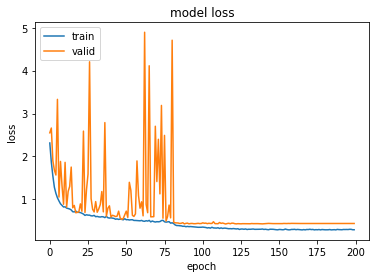

In [21]:
# plot the loss
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("./fig/modelLoss.png")
plt.show()

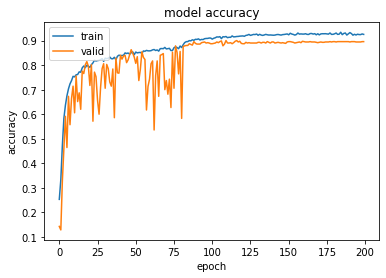

In [22]:
plt.plot(modelHistory.history['accuracy'])
plt.plot(modelHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("./fig/modelAcc.png")
plt.show()